# Home assignment 1 (65 pts)

## Problem 1 (25 pts)
---

Recently generative models have experience dramatic quality in terms of photorealism and quality of image generation
and it is becoming increasingly difficult to distinguish real and generated content.

In this task your goal is to develop a classifier with as high accuracy as possible that classifies whether the given image is real on synthetic.

In the following we will use the dataset from Kaggle [AI Generated Images vs Real Images](https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images/data) constructed from images scraped from the web and generated via modern generative models.

### Important notes

* You are allowed to use any pretrained model from `torchvision`, `timm` and `open_clip` . Use of any other source is <font color='red'>prohibited</font> !
* The amount of data is small. Recall the recipes and practices to combat overfitting you learned on lectures and seminars.
* In case you do not have `kaggle` account, create one and follow the instructions on [this page](https://www.kaggle.com/docs/api) to get Kaggle API token.

Prepare kaggle API token

In [ ]:
!pip install kaggle # already installed on Google Colab

Put the token in `/.kaggle` directory

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle

In [3]:
import os
import warnings
warnings.filterwarnings("ignore")
from typing import Tuple

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

### Dataset preparation
---

Please <font color='red'>do not change</font> the lines below!

Train and test split are expected to be the same for all submissions.

In [ ]:
# download and extract data
!kaggle datasets download -d cashbowman/ai-generated-images-vs-real-images
!unzip ai-generated-images-vs-real-images.zip

In [5]:
# split train/test data in 75/25% ration
test_ratio = 0.25
# generated images
ai_root = "AiArtData/AiArtData"
ai_paths = [os.path.join(ai_root, path) for path in os.listdir(ai_root)]
ai_labels = [0 for _ in ai_paths]
# real images
real_root = "RealArt/RealArt"
real_paths = [os.path.join(real_root, path) for path in os.listdir(real_root)]
real_labels = [1 for _ in real_paths]
# concatenate
all_img_paths = [*ai_paths, *real_paths]
all_labels = [*ai_labels, *real_labels]

train_img_paths, test_img_paths, train_labels, test_labels = train_test_split(
    all_img_paths, all_labels, test_size=0.25, random_state=42
)

Let us visualize some samples


In [6]:
import matplotlib.pyplot as plt

Real images

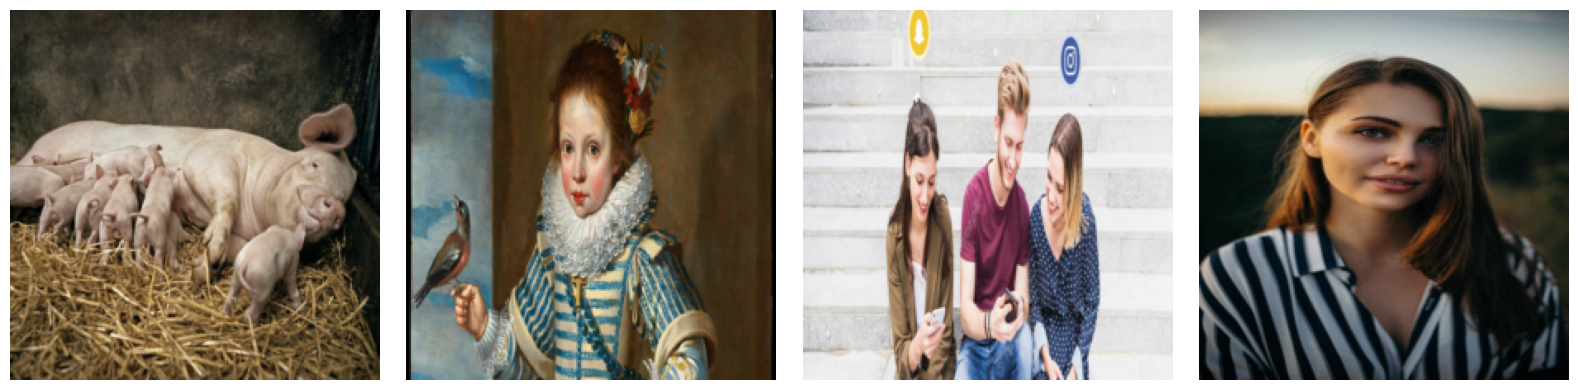

In [7]:
resize = T.Resize((224, 224))

fig, ax = plt.subplots(ncols=4, figsize=(4 * 4, 4))
for i in range(4):
    img = Image.open(real_paths[i])
    ax[i].imshow(resize(img))
    ax[i].axis('off')
fig.tight_layout()

Generated images

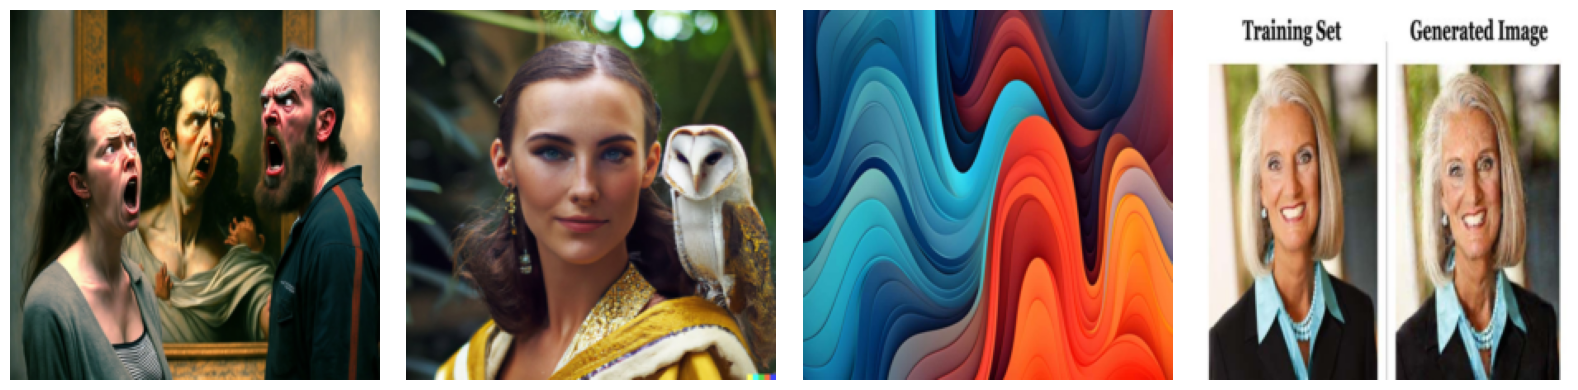

In [8]:
resize = T.Resize((224, 224))

fig, ax = plt.subplots(ncols=4, figsize=(4 * 4, 4))
for i in range(4):
    img = Image.open(ai_paths[i])
    ax[i].imshow(resize(img))
    ax[i].axis('off')
fig.tight_layout()

In [9]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # get image
        image = Image.open(self.img_paths[idx]).convert("RGB")
        # convert image to tensor
        if self.transform:
            image = self.transform(image)
        # get label
        label = self.labels[idx]
        return image, label

We will use ImageNet stats for normalization. (actual `mean` and `std` are quite close to the one for ImageNet)

In [10]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

1. **(1 pt )** Choose any reasonable traning transformation pipeline

In [11]:
import torchvision.transforms as T


train_transform = T.Compose([
    T.Resize((300, 300)),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.RandomPerspective(distortion_scale=0.5),
    T.RandomResizedCrop(224, scale=(0.5, 1.0)),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 64
train_dataset = ImageDataset(train_img_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


<font color='red'>Do not change</font> the transformations below! Evaluation setup is expected to be consistent across all submissions.

In [12]:
test_transforms = T.Compose([
    T.Resize(232, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean, std)]
)
test_dataset = ImageDataset(test_img_paths, test_labels, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)

### Model
---

2. **(1 pt)** Design your own model or take any pretrained, or train from scratch model from `torchvision`, `timm` or `open_clip`.

In [13]:
import torchvision.models
# import timm (you may need !pip install timm)
# import open_clip (you may need !pip install open_clip)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [15]:
import torchvision.models as models

class EnsembleModel(nn.Module):
    def __init__(self):
        super(EnsembleModel, self).__init__()

        # Increase the capacity of each sub-model
        self.model1 = models.resnet101(pretrained=True)
        num_ftrs1 = self.model1.fc.in_features
        self.model1.fc = nn.Sequential(
            nn.Linear(num_ftrs1, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

        self.model2 = models.resnet50(pretrained=True)
        num_ftrs2 = self.model2.fc.in_features
        self.model2.fc = nn.Sequential(
            nn.Linear(num_ftrs2, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        avg_out = (out1 + out2) / 2
        return avg_out



By default most models in `torchvision` or `timm` have 1000 classes. How many classes are in this case?

3. **(1 pt)** Build a classifier, suitable for a task of interest.

In [ ]:

model = EnsembleModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Prepare training loop and necessary functions.

4. **(1 pt)** Implement metric to measure model performance
5. **(3 pts)** Implement training loop
6. **(2 pts)** Implement validation loop

In [17]:
def binary_accuracy(logits: torch.Tensor, target: torch.Tensor) -> float:
    probs = torch.sigmoid(logits)
    preds = torch.round(probs)
    correct = (preds == target).float()
    acc = correct.sum() / len(correct)
    return acc.item()

# Define the training epoch function
def train_epoch(model, data_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_count = 0

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(inputs)
        loss = loss_fn(logits.squeeze(1), targets.float())
        loss.backward()
        optimizer.step()

        acc = binary_accuracy(logits.squeeze(1), targets)

        total_loss += loss.item() * inputs.size(0)
        total_acc += acc * inputs.size(0)
        total_count += inputs.size(0)

    avg_loss = total_loss / total_count
    avg_acc = total_acc / total_count
    return avg_loss, avg_acc

# Define the validation epoch function
def val_epoch(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_count = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            loss = loss_fn(logits.squeeze(1), targets.float())

            acc = binary_accuracy(logits.squeeze(1), targets)

            total_loss += loss.item() * inputs.size(0)
            total_acc += acc * inputs.size(0)
            total_count += inputs.size(0)

    avg_loss = total_loss / total_count
    avg_acc = total_acc / total_count
    return avg_loss, avg_acc


Now the goal is achieve as high accuracy as possible.

Set up any number of epochs, learning rate, regularization and other hyperparameters that yield best performance on hold-out data.

**Note**. If you decide to use early stopping, **do not use** ⛔ test data, that in practical cases is not available. You can create `devset` from subset of traning data.

In [18]:
num_epochs = 30
learning_rate = 1e-5
weight_decay = 5e-4

6. **(1 pt)** Prepare optimizer and scheduler.
7. **(1 pt)** Choose suitable loss function.

In [19]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        with torch.no_grad():
            target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
        return F.binary_cross_entropy_with_logits(pred, target_smooth)

# Usage
loss_fn = LabelSmoothingLoss(smoothing=0.1)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EnsembleModel(
  (model1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

8. **(max 15 pts)** Final performance.

The grading criteria are the following:
* Test accuracy $\in (0.00, 0.75)$ - **0 pts**
* Test accuracy $\in [0.75, 0.80)$ - **5 pts**
* Test accuracy $\in [0.80, 0.85)$ - **10 pts**
* Test accuracy $\in [0.85, 1.00)$ - **15 pts**

You are expected to provide **all the steps** that lead you to solution, i.e which ideas worked and which did not.

Submissions without decription of the experimental setup and the path that lead to the final result will receive **0 pts** for this section.

In [ ]:
best_val_acc = 0
train_accs = []
val_accs = []

for epoch in range(num_epochs):

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)
    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    val_loss, val_acc = val_epoch(model, test_loader, loss_fn, device)
    print(f"Epoch {epoch}: Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_weights.pth')

test_loss, test_acc = val_epoch(model, test_loader, loss_fn, device)
print(f"Final Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch 0: Train Loss: 0.6899, Train Acc: 0.5445
Epoch 0: Val Loss: 0.6707, Val Acc: 0.5697
Epoch 1: Train Loss: 0.6736, Train Acc: 0.5691
Epoch 1: Val Loss: 0.6576, Val Acc: 0.5738
Epoch 2: Train Loss: 0.6587, Train Acc: 0.6033
Epoch 2: Val Loss: 0.6424, Val Acc: 0.5820
Epoch 3: Train Loss: 0.6415, Train Acc: 0.6594
Epoch 3: Val Loss: 0.6236, Val Acc: 0.6148
Epoch 4: Train Loss: 0.6215, Train Acc: 0.7209
Epoch 4: Val Loss: 0.6026, Val Acc: 0.6926
Epoch 5: Train Loss: 0.5965, Train Acc: 0.7592
Epoch 5: Val Loss: 0.5840, Val Acc: 0.7131
Epoch 6: Train Loss: 0.5588, Train Acc: 0.8140
Epoch 6: Val Loss: 0.5686, Val Acc: 0.7295
Epoch 7: Train Loss: 0.5258, Train Acc: 0.8331
Epoch 7: Val Loss: 0.5578, Val Acc: 0.7541
Epoch 8: Train Loss: 0.5037, Train Acc: 0.8345
Epoch 8: Val Loss: 0.5422, Val Acc: 0.7705
Epoch 9: Train Loss: 0.4718, Train Acc: 0.8550
Epoch 9: Val Loss: 0.5252, Val Acc: 0.7787
Epoch 10: Train Loss: 0.4406, Train Acc: 0.8673
Epoch 10: Val Loss: 0.5181, Val Acc: 0.7828
Epoch 11

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve
import numpy as np
import itertools

model.load_state_dict(torch.load('/content/best_model_weights.pth'))
test_loss, test_acc = val_epoch(model, test_loader, loss_fn, device)
print(f"Final Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Final Test Loss: 0.3774, Test Acc: 0.8893


## **REPORT**

## **Introduction**
The assignement was to make a computer program that could tell the difference between images made by people and those created by artificial intelligence (AI). With lots of pictures out there, it's getting harder to tell them apart. My goal was to make this program accurate and reliable, using images from a Kaggle dataset for training and testing.

## **Dataset and Model Setup**
The dataset employed for this study was sourced from Kaggle, comprising a collection of both authentic and artificially generated images. To discern the origins of these images, I utilized an ensemble approach, leveraging the capabilities of two pre-trained models: ResNet101 and ResNet50. These models were integrated into a unified framework, wherein their outputs were averaged to produce a final classification decision.

# **Challenges Along the Way**
A few problems popped up during the project:

The program started to memorize the training images, so I had to adjust some settings and make the images more varied.
There were some errors when I tried to feed images into the program because they weren't all the same size. I fixed this by making all images uniform before they went in.
At first, the learning rate (how quickly the program learns from new data) was too high, which made the results a bit unstable. I fixed this by using a tool that adjusted the learning rate as needed. Though, removed it later because of some more complications.


# **Results and Simple Observations**




In [27]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_precision_recall_curve(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, marker='.')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()


y_true = []
y_pred = []
y_prob = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = torch.round(torch.sigmoid(logits)).cpu().numpy()
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(preds)
        y_prob.extend(probs)

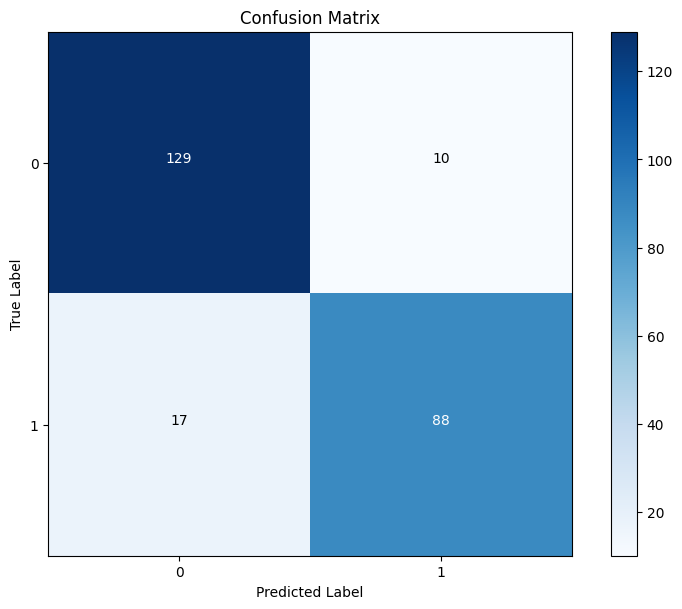

In [28]:
plot_confusion_matrix(y_true, y_pred)



The model showed proficiency in identifying real images with 129 correct predictions, but it was slightly less accurate with AI-generated images, correctly identifying 88 of them. Misclassifications were relatively low, with 10 AI-generated images mistaken as real and 17 real images labeled as AI-generated. Overall, the model demonstrated a balanced ability to classify both types of images accurately.

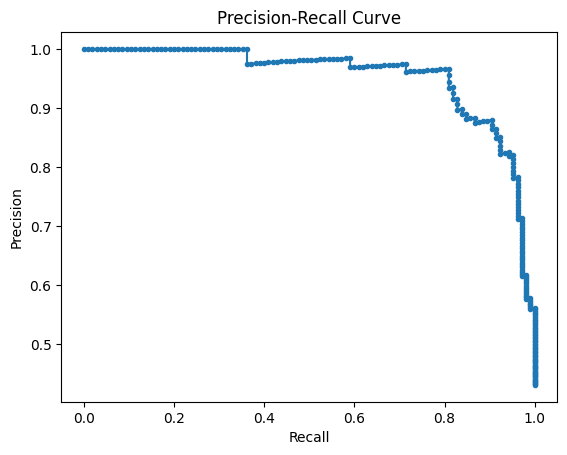

In [29]:
plot_precision_recall_curve(y_true, y_prob)



The precision-recall curve shows high precision at lower recall levels, indicating the model's strong accuracy when identifying the positive class. As recall increases, precision begins to decline, suggesting a trade-off between retrieving all relevant instances and maintaining accuracy. Overall, the model maintains a relatively high precision until recall extends beyond a certain threshold.

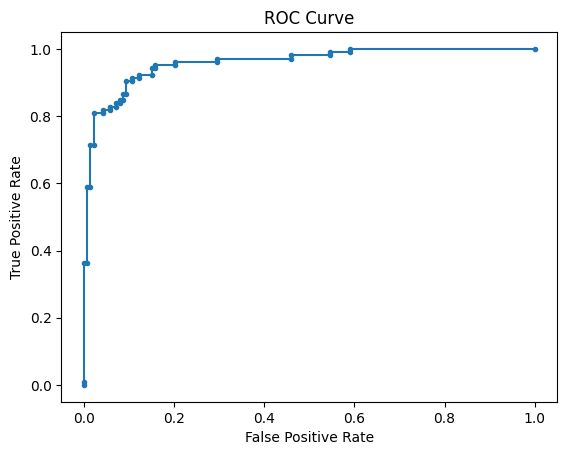

In [30]:
plot_roc_curve(y_true, y_prob)


The ROC curve demonstrates a model with a strong ability to differentiate between the classes, quickly achieving a high true positive rate with a low false positive rate. The curve's plateau near the top left corner suggests excellent model performance. The overall shape of the ROC curve indicates that the model is effective at maintaining a high true positive rate across various thresholds.

In [31]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       139
           1       0.90      0.84      0.87       105

    accuracy                           0.89       244
   macro avg       0.89      0.88      0.89       244
weighted avg       0.89      0.89      0.89       244



The model's performance for class 0 (real images) shows a precision of 0.88 and a recall of 0.93, leading to an F1-score of 0.91. For class 1 (AI-generated images), the precision is slightly higher at 0.90 with a recall of 0.84, yielding an F1-score of 0.87. Overall, the model has an accuracy of 0.89, with both macro and weighted averages across precision, recall, and F1-score being close to 0.89 for the 244 images it was tested on.